A* Tree Planner Demo Notebook

In [1]:
# ============================================================================
# CELL 1: Imports
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt

# Change working directory to the parent directory of this file
import os
from pathlib import Path

os.chdir("/Users/rbb242/research/balloon-outreach")

from env.balloon_env import BalloonERAEnvironment
from agent.tree_search_agent import run_astar

# For visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Configuration parameters
use_simplified_step = True  # Use simplified step for A* search
lat_long_atol = 1e-1        # Tolerance for latitude and longitude (degrees)
alt_atol = 1                # Tolerance for altitude (km)
environment_step = 1200     # Environment step in seconds
max_iter = 10000            # Maximum iterations for A* search 
max_depth = None            # Maximum depth for A* search (in discrete timesteps) - None means no limit.

In [3]:
# ============================================================================
# CELL 2: Demo Setup
# ============================================================================

# Demo Setup
# Ithaca to Canada, no noise in wind field.
np.random.seed(0)  # For reproducible results

# BalloonERAEnvironment initialization 
# 1. load your ERA5 file
ds = xr.open_dataset("era5_data.nc", engine="netcdf4")
# 2. pick a reference start_time (should match your dataset’s first valid_time)
start_time = dt.datetime(2024, 7, 1, 0, 0)
# Create environment and agent
env = BalloonERAEnvironment(ds=ds, start_time=start_time, viz=False, add_noise=False, dt=environment_step)
initial_state = env.get_balloon_state()  # Get the initial state of the balloon


WindField initialized with noise enabled: False


In [4]:
# Define start and target states

# Working start state and target state (0/0/10 pair)
# start_state = np.array([0.0, 0.0, 10.0])  # lat, lon, alt
# target_state = np.array([-0.0001, 0.035, 10.0])  # lat, lon, alt

# ITHACA. working start/end target states
start_state = np.array([42.6, -76.5, 10.0])  # lat, lon, alt
## Working target (dt=60)
# target_state = np.array([42.62, -76.5, 10.0])  # lat, lon, alt
## Working target (dt=6000)
target_state = np.array([47.5, -77, 8])  # lat, lon, alt

print(f"Start State:  Lat={start_state[0]:.3f}, Lon={start_state[1]:.3f}, Alt={start_state[2]:.1f} km")
print(f"Target State: Lat={target_state[0]:.3f}, Lon={target_state[1]:.3f}, Alt={target_state[2]:.1f} km")


Start State:  Lat=42.600, Lon=-76.500, Alt=10.0 km
Target State: Lat=47.500, Lon=-77.000, Alt=8.0 km


=== Tree Search (A*) Demo ===
Searching for optimal path...
Iteration 1/10000
Iteration 2/10000
Iteration 3/10000
Iteration 4/10000
Iteration 5/10000
Iteration 6/10000
Iteration 7/10000
Iteration 8/10000
Iteration 9/10000
Iteration 10/10000
Iteration 11/10000
Iteration 12/10000
Iteration 13/10000
Iteration 14/10000
Iteration 15/10000
Iteration 16/10000
Iteration 17/10000
Iteration 18/10000
Iteration 19/10000
Iteration 20/10000
Iteration 21/10000
Iteration 22/10000
Iteration 23/10000
Iteration 24/10000
Iteration 25/10000
Iteration 26/10000
Iteration 27/10000
Iteration 28/10000
Iteration 29/10000
Iteration 30/10000
Iteration 31/10000
Iteration 32/10000
Iteration 33/10000
Iteration 34/10000
Iteration 35/10000
Iteration 36/10000
Iteration 37/10000
Iteration 38/10000
Iteration 39/10000
Iteration 40/10000
Iteration 41/10000
Iteration 42/10000
Iteration 43/10000
Iteration 44/10000
Iteration 45/10000
Iteration 46/10000
Iteration 47/10000
Iteration 48/10000
Iteration 49/10000
Iteration 50/10000

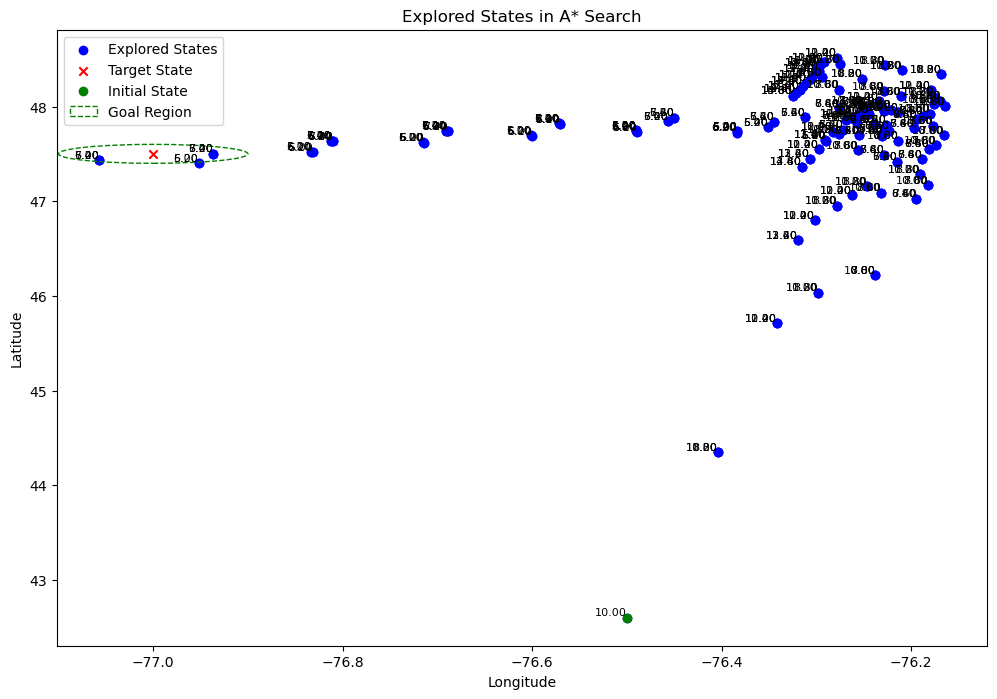

Action sequence to target: [((np.float64(42.6), np.float64(-76.5), np.float64(10.0), np.float64(0.0)), 'descend'), ((np.float64(44.35051873393737), np.float64(-76.40428844638176), np.float64(8.8), np.float64(0.3333333333333333)), 'descend'), ((np.float64(46.22134757961186), np.float64(-76.23778364922862), np.float64(7.6000000000000005), np.float64(0.6666666666666666)), 'descend'), ((np.float64(47.02775666866479), np.float64(-76.1943521863806), np.float64(6.4), np.float64(1.0)), 'descend'), ((np.float64(47.417782581711876), np.float64(-76.21474661114314), np.float64(5.2), np.float64(1.3333333333333333)), 'descend'), ((np.float64(47.63760043587881), np.float64(-76.29021968645122), np.float64(5.0), np.float64(1.6666666666666665)), 'stay'), ((np.float64(47.722603434186354), np.float64(-76.3841781077883), np.float64(5.0), np.float64(1.9999999999999998)), 'stay'), ((np.float64(47.726905151837414), np.float64(-76.4895326218284), np.float64(5.0), np.float64(2.333333333333333)), 'stay'), ((np.f

<Figure size 1200x800 with 0 Axes>

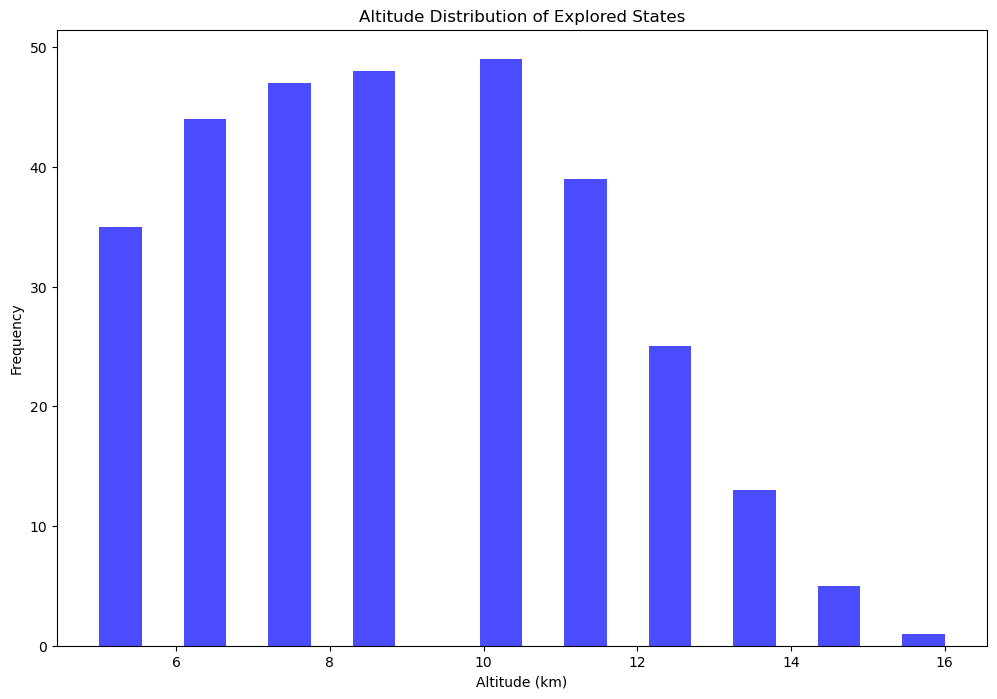

In [5]:
# ============================================================================
# CELL 9: Tree Search Demo
# ============================================================================

# Tree Search Demo
print("=== Tree Search (A*) Demo ===")

# Find optimal path
print("Searching for optimal path...")
# Reset the environment to the initial state
env.set_balloon_state(initial_state)
optimal_path = run_astar(env, initial_lat=start_state[0], initial_long=start_state[1], initial_alt=start_state[2],
            target_lat=target_state[0], target_lon=target_state[1], target_alt=target_state[2],
            distance='haversine', heuristic='haversine',
            plot_suffix="test_era_notebook", simplified_step=use_simplified_step,
            lat_long_atol=lat_long_atol, alt_atol=alt_atol, max_iter=max_iter, max_depth=max_depth)

if optimal_path:
    print(f"Found path with {len(optimal_path)} steps")
    print("Path:")
    for i, state in enumerate(optimal_path):
        print(f"  Step {i}: Lat={state[0][0]:.3f}, Lon={state[0][1]:.3f}, Alt={state[0][2]:.1f} km, Action={state[1]}")
else:
    print("No path found within iteration limit")

In [6]:
## Integrating with visualization code (ported from main.py, under run_episode())
import importlib.resources as pkg_resources
from pathlib import Path
from env.visualize import plot_trajectory_earth

# Robustly locate the texture image. Works for both namespace packages and local runs.
try:
    texture_path = pkg_resources.files("env").joinpath("figs/2k_earth_daymap.jpg")
except Exception:
    texture_path = Path(__file__).resolve().parent / "env" / "figs" / "2k_earth_daymap.jpg"

In [ ]:
if optimal_path:
    lats, lons, altitudes = zip(*[(state[0][0], state[0][1], state[0][2]) for state in optimal_path])

    try:
        plot_trajectory_earth(
            lats,
            lons,
            altitudes,
            texture_path=str(texture_path),
            lon_offset_deg=210,
            flip_lat=True,
        )
    except Exception as e:
        print(f"Plotly 3D visualization failed: {e}")

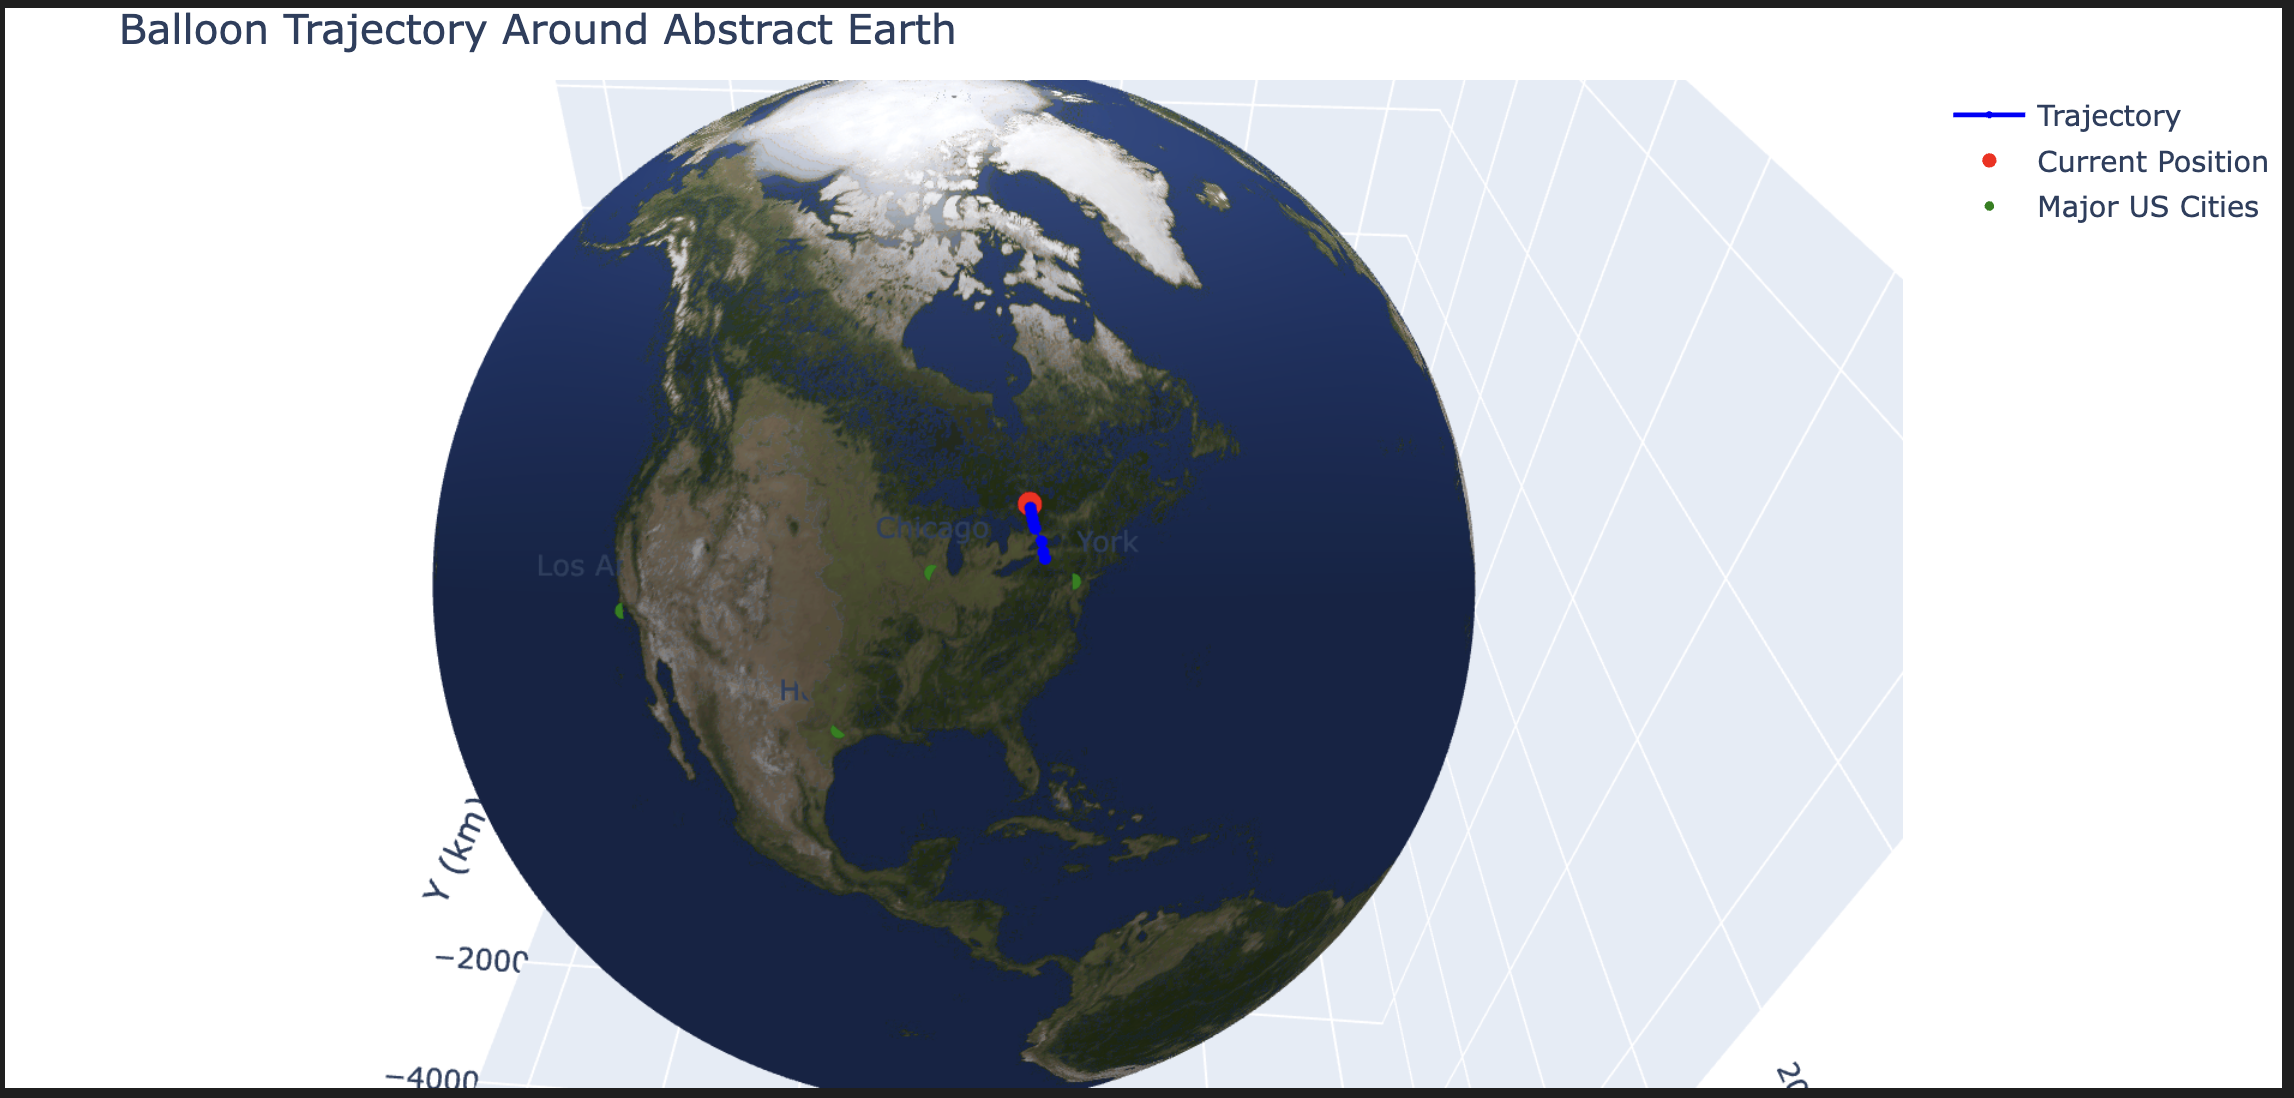

In [8]:
## Expected screencapture from visualization above.
from IPython.display import Image
Image(filename='plotly_screenshot_treesearch_20250707.png')